In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

df = pd.read_csv("product_data.csv",encoding="utf-8")
df.head(3)

,Unnamed: 0,prices,names,sku,ids,urls,locs,shops
0,0,9550000,%d8%b3%d8%b1%d8%ae-%da%a9%d9%86-%d8%a8%d8%af%d...,MAF10,71026,https://zardaan.com/product/%d8%b3%d8%b1%d8%ae...,T,کایان
1,1,8290000,%d8%b3%d8%b1%d8%ae-%da%a9%d9%86-%d8%a8%d8%af%d...,MAF10,71026,https://zardaan.com/product/%d8%b3%d8%b1%d8%ae...,nT,لیان کلاسیک
2,2,8600000,%d8%b3%d8%b1%d8%ae-%da%a9%d9%86-%d8%a8%d8%af%d...,MAF10,71026,https://zardaan.com/product/%d8%b3%d8%b1%d8%ae...,nT,هوم چین


In [2]:
def weighted_winsor(values, weights, alpha):
    n = len(values)
    k = int(math.floor(alpha * n))

    order = np.argsort(values)
    sorted_vals = values[order]
    sorted_weights = weights[order]

    if k > 0:
        low = sorted_vals[k]
        high = sorted_vals[-k-1]
        wins = np.clip(values, low, high)
    else:
        wins = values.copy()

    return wins


# -----------------------
# Trimmed Mean وزنی
# -----------------------
def weighted_trimmed_mean(values, weights, alpha):
    n = len(values)
    k = int(math.floor(alpha * n))

    order = np.argsort(values)
    vals = values[order]
    wts = weights[order]

    if k == 0:
        return float(np.sum(vals * wts) / np.sum(wts))

    vals_trim = vals[k:-k]
    wts_trim = wts[k:-k]

    return float(np.sum(vals_trim * wts_trim) / np.sum(wts_trim))


# -----------------------
# میانگین ترکیبی (Winsor + Trimmed + EMA)
# -----------------------
def combined_mean(values, weights, prev_mean=None,
                  alpha_winsor=0.05, alpha_trim=0.05, ema_factor=0.3):

    wins = weighted_winsor(values, weights, alpha_winsor)
    m1 = float(np.sum(wins * weights) / np.sum(weights))

    m2 = weighted_trimmed_mean(values, weights, alpha_trim)

    combined = 0.5 * m1 + 0.5 * m2

    if prev_mean is None:
        return combined
    else:
        # EMA نرم‌سازی
        return (1 - ema_factor) * prev_mean + ema_factor * combined


# -----------------------
# الگوریتم اصلی (هر تکرار ۵ ماکزیمم جایگزین)
# -----------------------
def optimize_prices(values, locations,
                    tehran_weight=1.4,
                    county_weight=1.0,
                    alpha_winsor=0.05,
                    alpha_trim=0.05,
                    replacement_count=5,
                    target_multiplier=1.15,
                    tehran_tolerance=0.07,
                    max_iters=20):

    v = np.array(values, dtype=float)
    locs = np.array(locations)
    if len(v)==0:
        return  0,
    if len(v)<=3:
        return (v.max()*1.1).item()

    weights = np.where(locs == 'T', tehran_weight, county_weight).astype(float)

    orig_min = v.min()
    target_min = target_multiplier * orig_min

    # میانگین تهران برای محدوده هدف
    if  len(v[locs == 'T'])!=0:
        tehran_mean = v[locs == 'T'].mean()
        low_t = tehran_mean * (1 - tehran_tolerance)
        high_t = tehran_mean * (1 + tehran_tolerance)
    else:
        tehran_mean = orig_min
        low_t = orig_min * (1-tehran_tolerance)
        high_t = orig_min * (1-tehran_tolerance)
    history = []

    current_mean = combined_mean(v, weights, prev_mean=None,
                                 alpha_winsor=alpha_winsor,
                                 alpha_trim=alpha_trim)

    history.append({"iter": 0, "mean": current_mean, "max": v.max()})

    for it in range(1, max_iters + 1):

        # شرط توقف: هر دو باید برقرار باشد
        cond1 = current_mean >= target_min
        cond2 = (current_mean >= low_t) and (current_mean <= high_t)

        if cond1 and cond2:
            break

        # پیدا کردن ۵ ماکزیمم
        max_indices = np.argsort(-v)[:replacement_count]

        # جایگزینی با میانگین فعلی
        for idx in max_indices:
            v[idx] = current_mean

        # محاسبه میانگین جدید
        prev = current_mean
        current_mean = combined_mean(v, weights, prev_mean=prev,
                                     alpha_winsor=alpha_winsor,
                                     alpha_trim=alpha_trim)

        history.append({
            "iter": it,
            "mean": current_mean,
            "max": v.max(),
            "replaced_indices": max_indices.tolist()
        })

    return current_mean if  len(v[locs == 'T'])!=0 else current_mean*1.2


In [3]:
import numpy as np

def calculate_fair_values(data):
    # 1. حذف 10 درصد پایین و بالا داده‌ها
    data_sorted = np.sort(data)
    n = len(data_sorted)
    lower_bound = int(n * 0.1)
    upper_bound = int(n * 0.9)
    trimmed_data = data_sorted[lower_bound:upper_bound]
    
    # 2. محاسبه میانه
    median_value = np.median(trimmed_data)
    
    # 3. تعیین وزن‌ها: 1.2 به داده‌های کوچکتر (نیمه پایین)، 1 به داده‌های بزرگتر (نیمه بالا)
    mid_index = len(trimmed_data) // 2
    weights = np.ones(len(trimmed_data))
    weights[:mid_index] = 1.2
    
    # 4. محاسبه میانگین وزنی گاوس
    weighted_mean = np.ma.average(trimmed_data, weights=weights)
    
    # 5. محاسبه میانگین ساده میانه و میانگین وزنی
    combined_mean = (median_value + weighted_mean) / 2
    
    return float(combined_mean.item())



In [4]:
from scipy.stats import norm
def gaussian_fit(data):
    mu = np.mean(data)
    sigma = np.std(data)
    q4 = norm.ppf(q=0.4,loc=mu,scale=sigma)
    q5 = norm.ppf(q=0.5,loc=mu,scale=sigma)
    return ((q5-q4)//2).item()


In [5]:
def minimum_fair_price(prices):
    # حذف مقادیر صفر یا ناموجود
    filtered_prices = [p for p in prices if p and p > 0]

    # مرتب‌سازی داده‌ها
    prices_sorted = np.sort(filtered_prices)
    n = len(prices_sorted)
    if n < 3:
        return None  # یا پیغام مناسب
    
    # حذف 10 درصد ابتدا و انتهای لیست (پرت)
    lower = int(n * 0.1)
    upper = int(n * 0.9)
    trimmed = prices_sorted[lower:upper]

    # شرط 1: 10٪ بالاتر از حداقل قیمت تهران
    min_tehran = prices_sorted.min()
    cond_1 = min_tehran * 1.1

    # شرط 2: میانگین نرمال (گائوسی) پس از حذف پرت‌ها
    mean_gauss = np.mean(trimmed)
    cond_2 = mean_gauss

    # شرط 3: میانه داده‌های باقی‌مانده
    median_gauss = np.median(trimmed)
    cond_3 = median_gauss

    # شرط 4: کمتر از حداکثر قیمت تهران
    max_tehran = prices_sorted.max()
    cond_4 = max_tehran

    # شرط 5: 20٪ بالاتر از حداقل کل قیمت‌ها
    min_all = prices_sorted.min()
    cond_5 = min_all * 1.2

    # انتخاب بیشترین مقدار کف از شروط و کمتر از سقف بیشینه
    minimum_value = max(cond_1, cond_2, cond_3, cond_5)
    final_value = min(minimum_value, cond_4)

    # رند کردن به نزدیک‌ترین ضریب ۵۰,۰۰۰ تومان بالا
    rounded_value = int(np.ceil(final_value / 50000) * 50000)
    return rounded_value


In [6]:
def applyOptimization(g):
    Q4 = g["prices"].quantile(1)
    Q1 = g["prices"].quantile(.25)
    mask = g["prices"].between(Q1, Q4, inclusive="both")
    filtered = g.loc[mask]
    if len(filtered)>0:
        return pd.Series({
                "winzor": optimize_prices(filtered["prices"], filtered["locs"]),
                "gaussian1": calculate_fair_values(filtered["prices"]),
                "gaussian2": minimum_fair_price(filtered["prices"]),
                "sellerCount":len(filtered),
                "max":max(filtered["prices"]),
                "sku":max(filtered["sku"])
            })


result =  df[["ids","sku","prices","locs"]].groupby("ids").apply(
	    applyOptimization
)
result

c:\Users\Mirza\Projects\Python-Selenium-Action\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Mirza\Projects\Python-Selenium-Action\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Mirza\Projects\Python-Selenium-Action\.venv\Lib\site-packages\numpy\ma\extras.py:725: RuntimeWarning: invalid value encountered in scalar divide
  avg = np.multiply(a, wgt,
c:\Users\Mirza\Projects\Python-Selenium-Action\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Mirza\Projects\Python-Selenium-Action\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Mirza\Projects\Python-Selenium-Ac

,winzor,gaussian1,gaussian2,sellerCount,max,sku
ids,,,,,,
14820,1.195909e+07,8.605469e+06,10600000.0,4.0,18097000.0,NaN
15022,3.289000e+07,2.285766e+07,23900000.0,3.0,29900000.0,A163
15053,2.043437e+07,1.791112e+07,19800000.0,7.0,25697000.0,A1609
15063,1.749000e+07,1.572790e+07,NaN,2.0,15900000.0,A2674-1
20947,1.741538e+07,1.778182e+07,20400000.0,23.0,24750000.0,KLF03
...,...,...,...,...,...,...
89291,1.391052e+07,1.334358e+07,13700000.0,29.0,77689000.0,AF100
89296,9.448161e+06,9.103288e+06,9850000.0,186.0,70000000.0,NA230
89306,8.783799e+06,9.223121e+06,9750000.0,133.0,330000000.0,HD9270/91


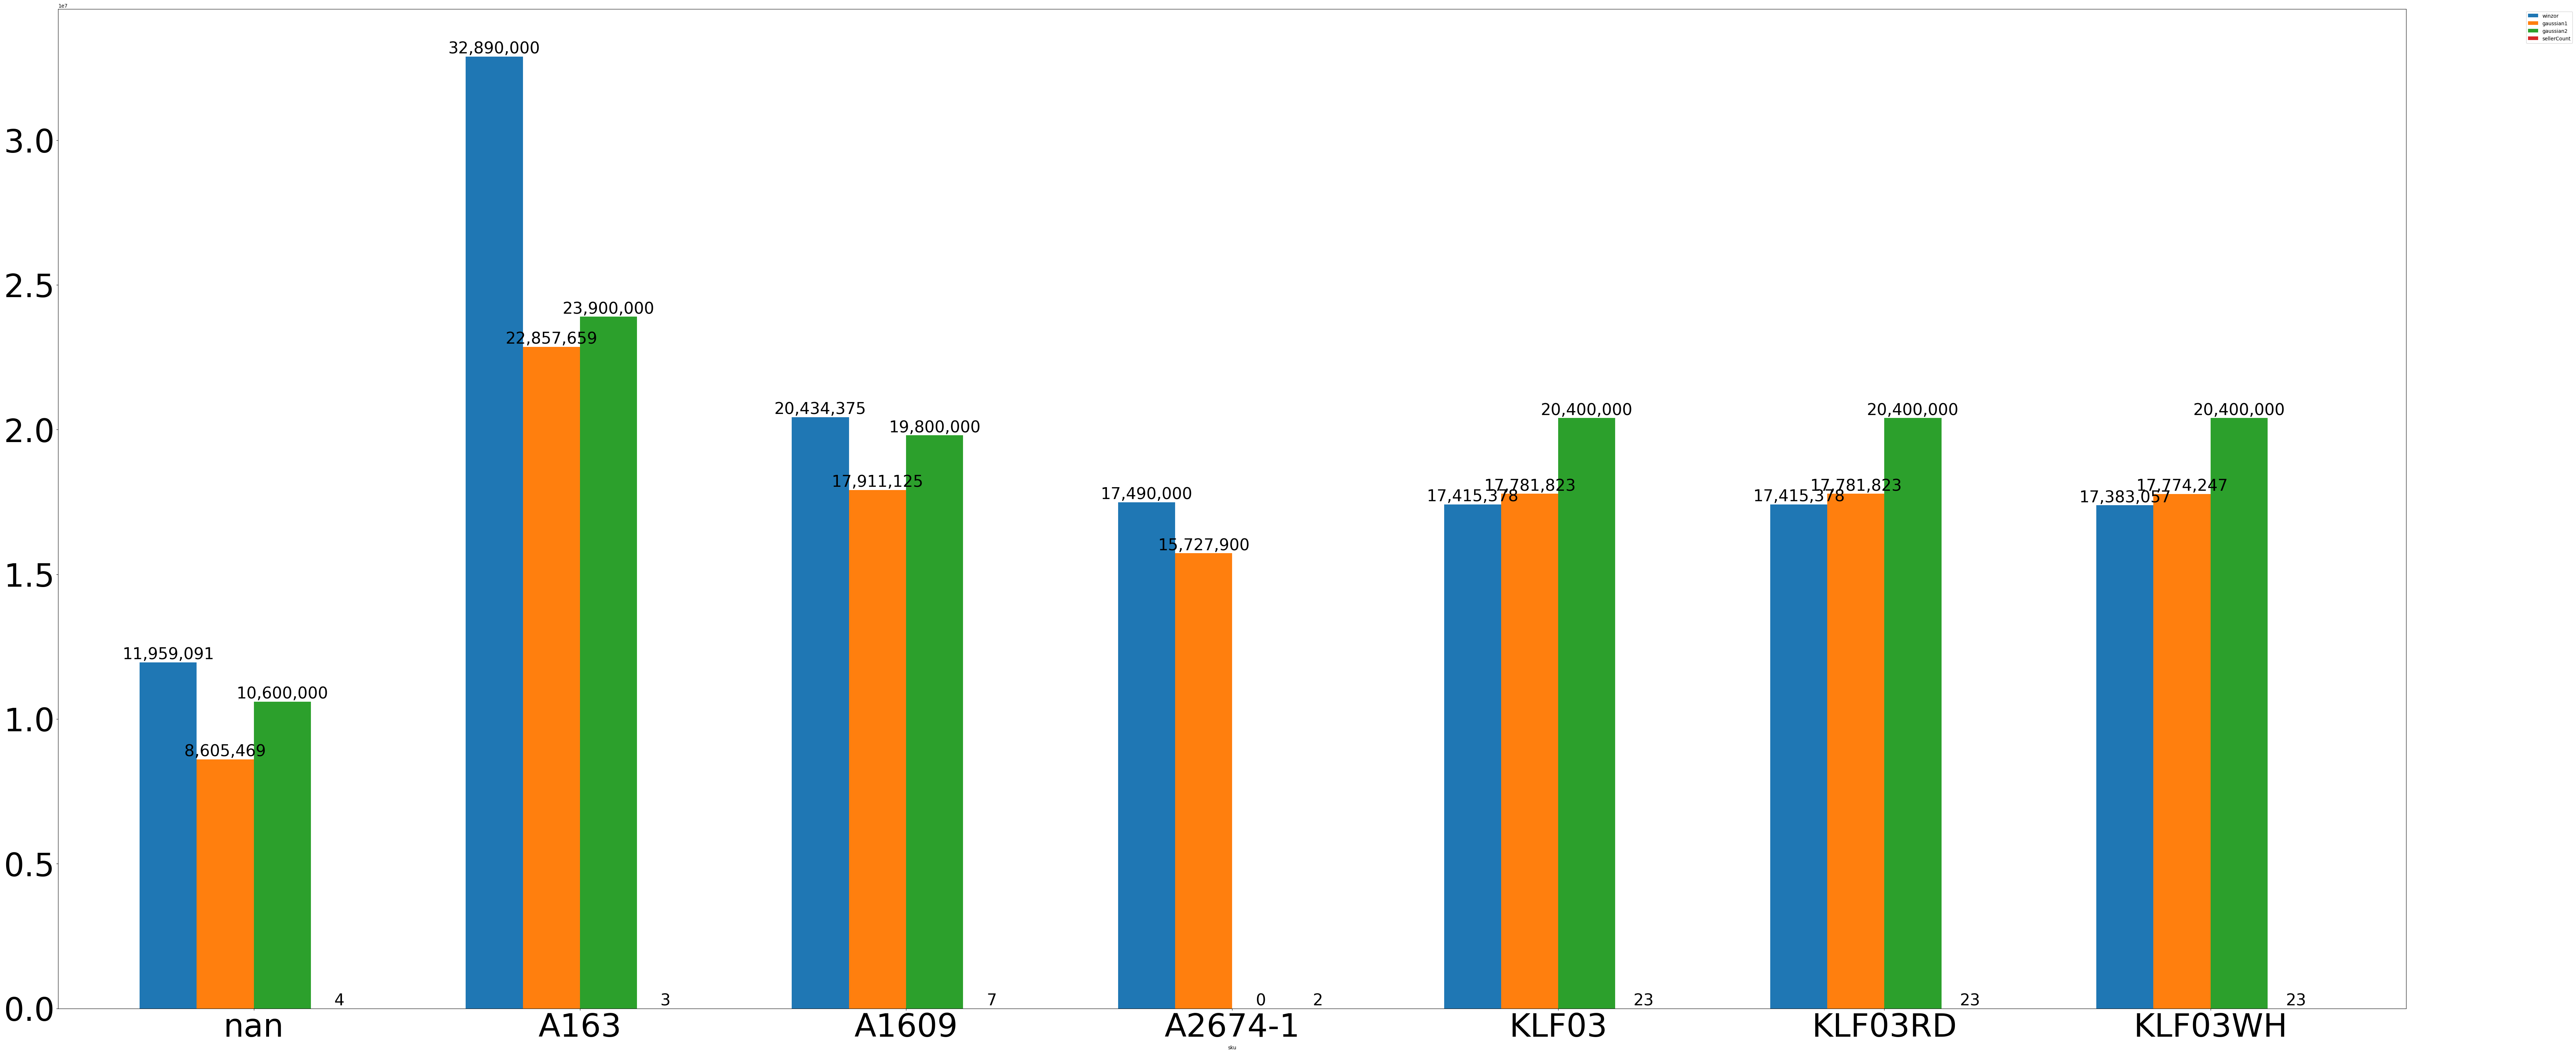

In [16]:
plotRes = result.head(7).drop("max",axis=1)
ax = plotRes.plot.bar(x="sku",figsize=(len(plotRes)*12, 36), width=0.7,fontsize=64)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
rects = ax.patches
for index, rect in enumerate(rects):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, '{:,.0f}'.format(height),
                ha='center', va='bottom',fontsize=32)

plt.show()

In [41]:
# Source - https://stackoverflow.com/a/73650870
# Posted by SimfikDuke
# Retrieved 2025-12-06, License - CC BY-SA 4.0
import time 
import asyncio
class Limiter:
    def __init__(self, calls_limit: int = 5, period: int = 1):
        self.calls_limit = calls_limit
        self.period = period
        self.semaphore = asyncio.Semaphore(calls_limit)
        self.requests_finish_time = []

    async def sleep(self):
        if len(self.requests_finish_time) >= self.calls_limit:
            sleep_before = self.requests_finish_time.pop(0)
            if sleep_before >= time.monotonic():
                await asyncio.sleep(sleep_before - time.monotonic())

    def __call__(self, func):
        async def wrapper(*args, **kwargs):

            async with self.semaphore:
                await self.sleep()
                res = await func(*args, **kwargs)
                self.requests_finish_time.append(time.monotonic() + self.period)

            return res

        return wrapper


In [ ]:
rounding = 1e5
import requests

result = result.dropna()
f = open("output.json","w")
ss ='{"result":['
def updateWeb():
	global ss
	for i,r in result.iterrows():
		rounded = round(max(r.winzor,r.gaussian1,r.gaussian2)/rounding*1.17)*rounding
		body = {
				"id":i,
				"price":rounded,
				"stock": 0 if r.sellerCount<5 else 10,
		} 
		pageResponse = requests.post(f"https://zardaan.com/wp-json/torob/v1/UPDATE/",data=body)
		ss+=pageResponse.text+","
updateWeb()
ss = ss[:-1]+"]}"
f.write(ss)

ClientConnectorError: Cannot connect to host zardaan.com:443 ssl:default [An existing connection was forcibly closed by the remote host]

In [30]:
type(result)

pandas.core.frame.DataFrame

In [19]:
row = result.loc[result["sku"]=="HD9270/91"]
for p in (row["winzor"].item(),row.gaussian1.item(),row.gaussian2.item()):
	print("{:,}".format(p))
print(row.sku)

8,783,798.795173464
9,223,121.196397942
9,750,000.0
ids
89306    HD9270/91
Name: sku, dtype: object


In [21]:
fdf = df.loc[df["sku"]=="HD9270/91"]
' '.join('{:_.0f}'.format(x) for x in fdf["prices"].values)

'8_399_000 6_548_000 6_549_000 6_590_000 6_800_000 6_900_000 7_000_000 7_100_000 7_175_000 7_295_000 7_500_000 7_590_000 7_600_000 7_700_000 7_800_000 7_800_000 7_870_000 7_900_000 7_900_000 7_900_000 7_900_000 7_940_000 7_950_000 7_970_000 7_970_000 7_990_000 8_000_000 8_000_000 8_000_000 8_000_000 8_000_000 8_000_000 8_000_000 8_000_000 8_000_000 8_040_000 8_075_000 8_078_500 8_099_000 8_100_000 8_150_000 8_162_000 8_199_999 8_200_000 8_200_000 8_200_000 8_200_000 8_228_000 8_232_000 8_249_000 8_249_000 8_250_000 8_255_000 8_280_000 8_280_000 8_300_000 8_300_000 8_300_000 8_300_000 8_349_000 8_350_000 8_360_000 8_397_000 8_399_000 8_400_000 8_400_000 8_400_000 8_500_000 8_500_000 8_500_000 8_554_000 8_580_000 8_600_000 8_600_000 8_655_000 8_660_000 8_662_000 8_700_000 8_700_000 8_750_000 8_790_000 8_790_000 8_798_000 8_800_000 8_800_000 8_800_000 8_800_000 8_800_000 8_800_000 8_858_100 8_900_000 8_900_000 8_900_000 8_950_000 8_999_000 9_000_000 9_000_000 9_082_000 9_100_000 9_150_000